In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import os
import copy
import time
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spark dependencies
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import StorageLevel, SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.mllib.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime, timedelta
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import col, expr, udf, sequence

# Other configs
pd.options.display.float_format = "{:.2f}".format

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"

nodes_1to50=pd.read_parquet(data_path+"/02_intermediate/consumption_total_average_30min_W_1_to_50_repartition")

In [5]:
nodes_1to50

,time,total_average_power_consumption_W
0,2017-12-31 23:00:00,0.00
1,2017-12-31 23:30:00,9756.00
2,2018-01-01 00:00:00,9723.13
3,2018-01-01 00:30:00,9761.04
4,2018-01-01 01:00:00,9732.96
...,...,...
61244,2021-06-29 20:00:00,0.00
61245,2021-06-29 20:30:00,0.00
61246,2021-06-29 21:00:00,0.00
61247,2021-06-29 21:30:00,0.00


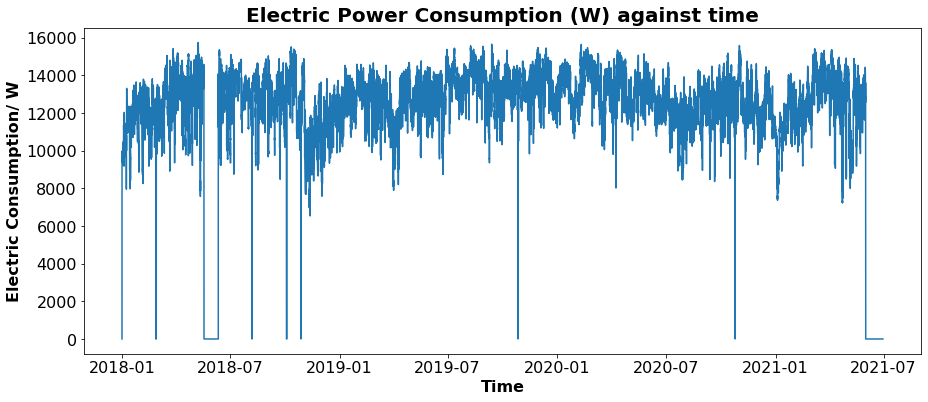

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(nodes_1to50['time'], nodes_1to50['total_average_power_consumption_W'] )

ax.set_title('Electric Power Consumption (W) against time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Electric Consumption/ W', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [1]:
## Imports
from pyspark.sql import SparkSession
from pyspark import SparkContext
import os
import copy
import time
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spark dependencies
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import StorageLevel, SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.mllib.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime, timedelta
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import col, expr, udf, sequence

# Other configs
pd.options.display.float_format = "{:.2f}".format

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"

# Start counting time
start_t = time.time()
# Reading the original file
df = spark.read.parquet(
    "output_final.parquet"
)  # Functional programming. Reading the raw data file with the Structured API
# df.printSchema()
df.createOrReplaceTempView("df")

# Generating a dataFrame with the times (every 30 minutes from start_timestamp to end_timestamp)
dates = pd.date_range(
    start=datetime(2018, 1, 1, 0, 0, 0),
    end=datetime(2021, 6, 30, 0, 0, 0),
    freq="30min",
)
datetimes = [date.to_pydatetime() for date in dates]
time_df = (
    spark.createDataFrame(datetimes, TimestampType())
    .withColumnRenamed("value", "time")
    .sort(F.asc("time"))
)

# Obtaning each consumption node in a list
node_list = (
    spark.sql("SELECT node from df").rdd.flatMap(lambda x: x).collect()
)  # Getting the list with all the node names


# Obtaning each consumption node:
# We are having two time related Spark Dataframes that originally prior to iterate will be identical
# time_df: will remain unchanged during the whole execution, just a reference to ensure all the times are met and if not a null is given for the corresponding electrical consumption column
# consumption_df: this will suffer a left join at the end of each iteration and will be the container for all the consumption columns
consumption_df = spark.createDataFrame(time_df.rdd, time_df.schema)
consumption_df = consumption_df.withColumn("total_average_power_consumption_W", lit(0))
for node in node_list[80:110]:  # All the consumption related cluster nodes
    sql_query_node_consumption = """
                    SELECT 
                        EXPLODE(power) as (time, node_{}_power_consumption) 
                    FROM df
                    WHERE 
                        node LIKE "{}"
                """.format(
        node, node
    )
    node_consumption = spark.sql(sql_query_node_consumption)
    node_consumption = node_consumption.withColumn(
        "time", F.to_timestamp(node_consumption.time, "yyyy-MM-dd HH:MM:SS")
    )
    node_consumption = node_consumption.groupBy(
        "time", F.window("time", "30 minutes")
    ).agg(
        avg("node_{}_power_consumption".format(node)).alias(
            "node_{}_power_consumption".format(node)
        ),
    )
    node_consumption = node_consumption.select(
        "time", "window.*", "node_{}_power_consumption".format(node)
    ).sort(F.asc("time"))
    node_consumption = node_consumption.select(
        col("end").alias("time"), col("node_{}_power_consumption".format(node))
    )
    node_consumption = node_consumption.groupBy("time").agg(
        avg("node_{}_power_consumption".format(node)).alias(
            "node_{}_average_power_consumption".format(node)
        )
    )
    node_consumption = node_consumption.select(
        "time", "node_{}_average_power_consumption".format(node)
    ).sort(F.asc("time"))
    consumption_df = consumption_df.join(node_consumption, ["time"], how="left").sort(
        F.asc("time")
    )
    consumption_df = consumption_df.fillna(0, subset=["node_{}_average_power_consumption".format(node)])
    consumption_df = consumption_df.withColumn("total_average_power_consumption_W", col("total_average_power_consumption_W")+col("node_{}_average_power_consumption".format(node)))
    consumption_df = consumption_df.drop("node_{}_average_power_consumption".format(node))
# consumption_df.cache()

consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
end_t = time.time()
print("Time in seconds " + str(end_t - start_t))


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 39360)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41856)
Traceback (most recent call last):
  File "/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21174d168bec>", line 113, in <module>
    consumption_df.repartition(1).write.parquet("consumption_total_average_30min_W_81_to_110")
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/readwriter.py", line 841, in parquet
    self._jwrite.parquet(path)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "

Py4JError: An error occurred while calling o2096.parquet